<a href="https://colab.research.google.com/github/bryaanabraham/Deep-Fake-AI/blob/main/Weights_deduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
from PIL import Image
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from google.colab import drive

Some Drawbacks:
- Requires a suspect for weight calculations
- Generalization might be subjective

# Data Loading

In [86]:
drive.mount('/content/drive')
fake_frames_dir = '/content/drive/MyDrive/Frames/frames_fake'
original_frames_dir = '/content/drive/MyDrive/Frames/frames_original'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
def get_image_files(directory, extension="jpg"):
  image_files = []
  pattern = os.path.join(directory, f"*.{extension}")
  image_files.extend(glob.glob(pattern))
  return image_files

In [88]:
fake_images = get_image_files(fake_frames_dir)
original_images = get_image_files(original_frames_dir)

In [89]:
fake_images.sort()
original_images.sort()

# Logic used:
- difference in pixel's RGB values are used to to determine a weight matrix
- The weight matrix is then used to perform calculation of original image

In [185]:
fake_image = Image.open(fake_images[0])
fake_image_array = np.array(fake_image)

original_image = Image.open(original_images[0])
original_image_array = np.array(original_image)

In [186]:
weight_array = original_image_array - fake_image_array

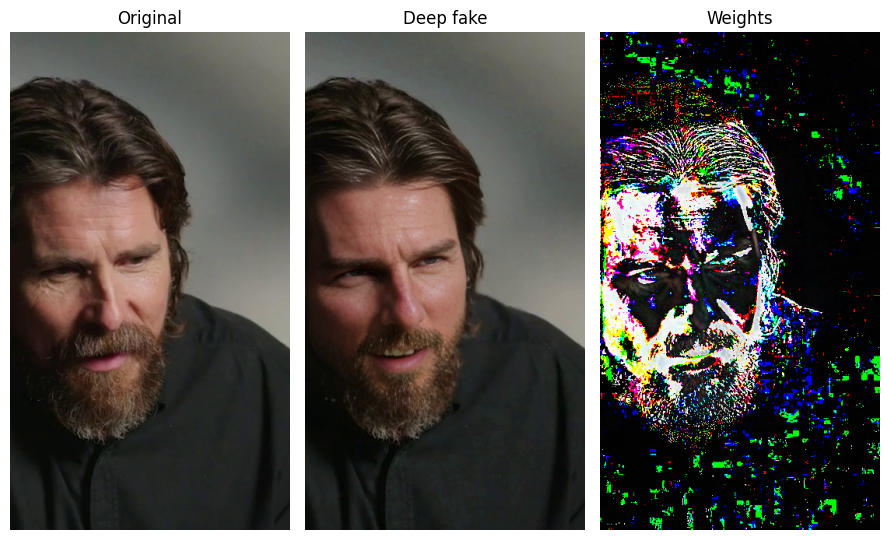

In [187]:
fig, axes = plt.subplots(1, 3, figsize=(9,6))
captions = ['Original', 'Deep fake', 'Weights']

axes[0].imshow(original_image_array)
axes[0].set_title(captions[0])
axes[0].axis('off')

axes[1].imshow(fake_image_array)
axes[1].set_title(captions[1])
axes[1].axis('off')

axes[2].imshow(weight_array)
axes[2].set_title(captions[2])
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [188]:
reversed_array = fake_image_array + weight_array

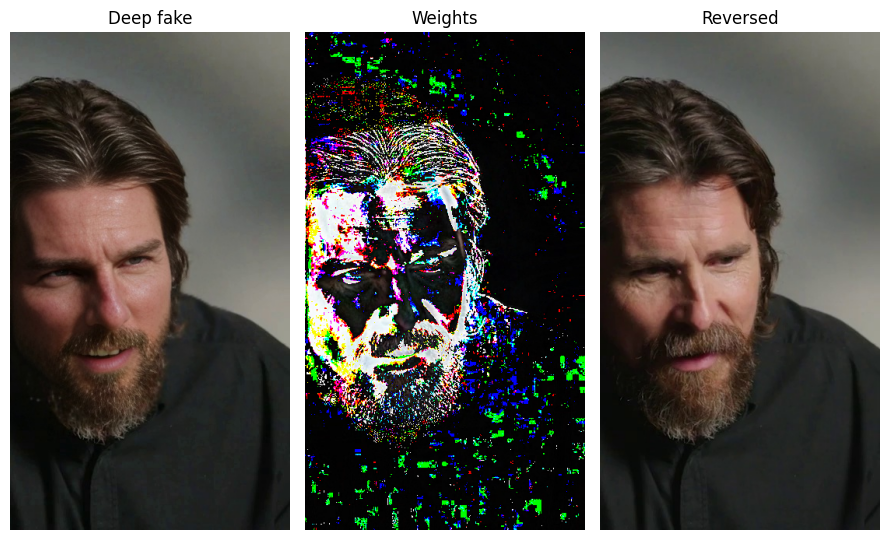

In [189]:
fig, axes = plt.subplots(1, 3, figsize=(9,6))
captions = ['Deep fake','Weights', 'Reversed']

axes[0].imshow(fake_image_array)
axes[0].set_title(captions[0])
axes[0].axis('off')

axes[1].imshow(weight_array)
axes[1].set_title(captions[1])
axes[1].axis('off')

axes[2].imshow(reversed_array)
axes[2].set_title(captions[2])
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Generalization
- The above logic was implemented for a single image
- a generalized weight matrix needs to be calculated which is applicable to all frames

In [219]:
original_image = Image.open(original_images[0])
original_image_array = np.array(original_image)

In [220]:
fake_image = Image.open(fake_images[0])
fake_image_array = np.array(fake_image)

In [221]:
fake_image = Image.open(fake_images[0])
fake_image_array = np.array(fake_image)
df_fake = pd.DataFrame(fake_image_array.reshape(-1, 3), columns=['R', 'G', 'B'])

original_image = Image.open(original_images[0])
original_image_array = np.array(original_image)
df_original = pd.DataFrame(original_image_array.reshape(-1, 3), columns=['R', 'G', 'B'])

In [222]:
for i in range(1,len(fake_images)):
  fake_image = Image.open(fake_images[i])
  fake_image_array = np.array(fake_image)
  df_fake_temp = pd.DataFrame(fake_image_array.reshape(-1, 3), columns=['R', 'G', 'B'])
  df_fake += df_fake_temp

  original_image = Image.open(original_images[i])
  original_image_array = np.array(original_image)
  df_original_temp = pd.DataFrame(original_image_array.reshape(-1, 3), columns=['R', 'G', 'B'])
  df_original += df_original_temp

df_difference = (df_original - df_fake) / len(fake_images)
weight_array = df_difference.to_numpy().reshape(640, 360, 3).astype(np.uint8)

(-0.5, 359.5, 639.5, -0.5)

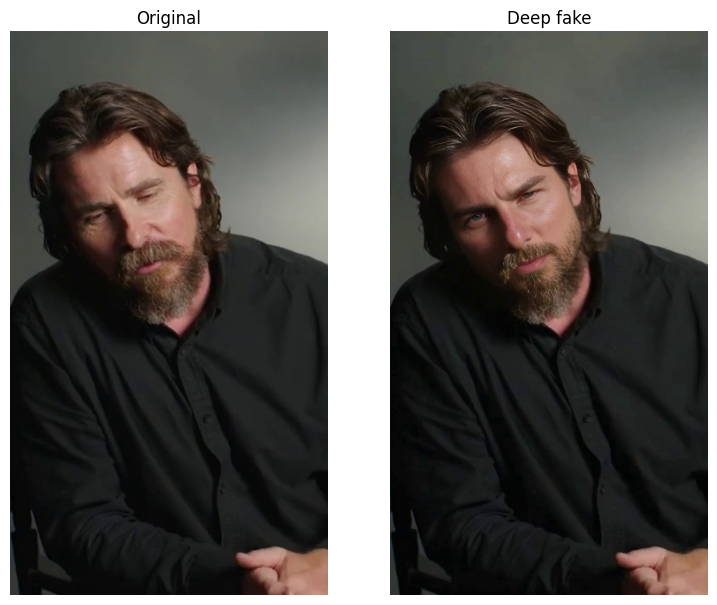

In [223]:
fig, axes = plt.subplots(1, 2, figsize=(9,9))
captions = ['Original', 'Deep fake',]

axes[0].imshow(original_image_array)
axes[0].set_title(captions[0])
axes[0].axis('off')

axes[1].imshow(fake_image_array)
axes[1].set_title(captions[1])
axes[1].axis('off')

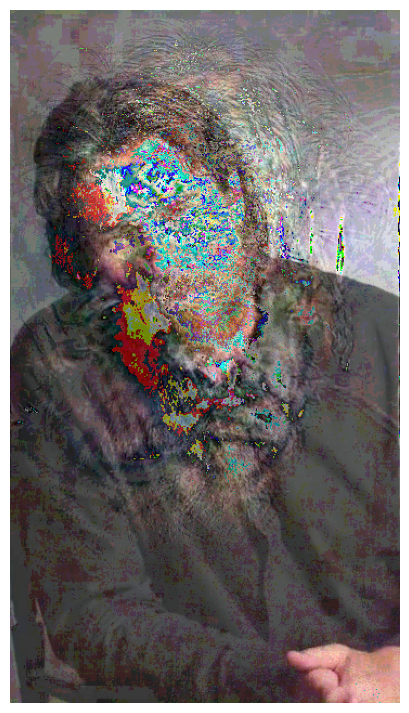

In [225]:
reversed_array = fake_image_array + weight_array*25
plt.figure(figsize=(9,9))
plt.imshow(reversed_array)
plt.axis('off')
plt.show()

# Face Detection

Resource for pretrained model : [Link](https://colab.research.google.com/github/dortmans/ml_notebooks/blob/master/face_detection.ipynb)

In [100]:
import imutils
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

In [101]:
!wget -N https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
!wget -N https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel

--2024-08-19 17:08:46--  https://raw.githubusercontent.com/opencv/opencv/master/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28104 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.45K  --.-KB/s    in 0.008s  

Last-modified header missing -- time-stamps turned off.
2024-08-19 17:08:46 (3.22 MB/s) - ‘deploy.prototxt’ saved [28104/28104]

--2024-08-19 17:08:46--  https://raw.githubusercontent.com/opencv/opencv_3rdparty/dnn_samples_face_detector_20170830/res10_300x300_ssd_iter_140000.caffemodel
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

In [102]:
print("[INFO] loading model...")
prototxt = 'deploy.prototxt'
model = 'res10_300x300_ssd_iter_140000.caffemodel'
net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


In [228]:
def detectFace(image_path, startX=0, startY=0, endX=0, endY=0):
  image = cv2.imread(image_path)
  image = imutils.resize(image, width=400)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  net.setInput(blob)
  detections = net.forward()
  for i in range(0, detections.shape[2]):

    confidence = detections[0, 0, i, 2]

    if confidence > 0.5:
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      # image = image[startY:endY, startX:endX]

  return startX, startY, endX, endY

In [146]:
image_path = '/content/image.jpg'

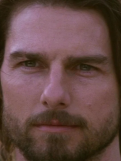

In [148]:
image = detectFace(image_path)
cv2_imshow(image)

In [229]:
fake_startX, fake_startY, fake_endX, fake_endY = detectFace(fake_images[0])
original_startX, original_startY, original_endX, original_endY = detectFace(original_images[0])

startX, startY, endX, endY = min(fake_startX,original_startX), max(fake_startY,original_startY), max(fake_endX, original_endX), min(fake_endY, original_endY)

fake_image = cv2.imread(fake_images[0])
fake_image = fake_image[startY:endY, startX:endX]
fake_image_array = np.array(fake_image)

original_image = cv2.imread(original_images[0])
original_image = original_image[startY:endY, startX:endX]
original_image_array = np.array(original_image)

In [231]:
weight_array = original_image_array - fake_image_array

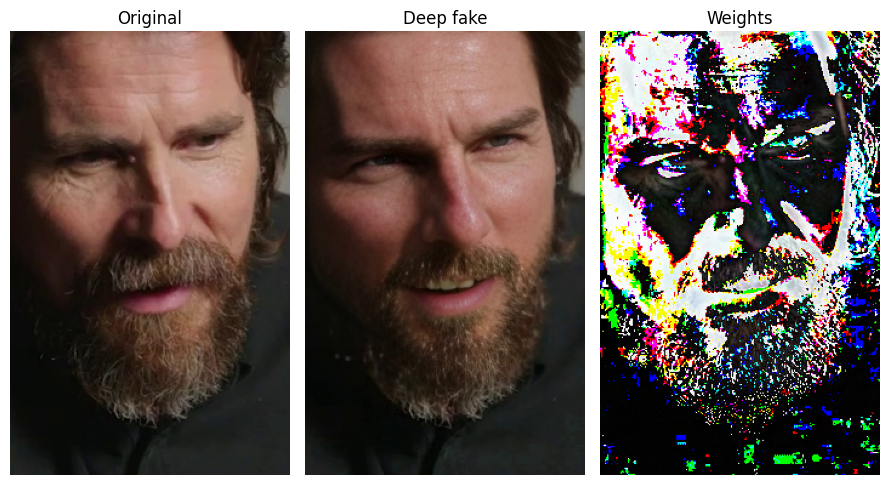

In [232]:
fig, axes = plt.subplots(1, 3, figsize=(9,6))
captions = ['Original', 'Deep fake', 'Weights']

axes[0].imshow(cv2.cvtColor(original_image_array, cv2.COLOR_BGR2RGB))
axes[0].set_title(captions[0])
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(fake_image_array, cv2.COLOR_BGR2RGB))
axes[1].set_title(captions[1])
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(weight_array, cv2.COLOR_BGR2RGB))
axes[2].set_title(captions[2])
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [233]:
reversed_array = fake_image_array + weight_array

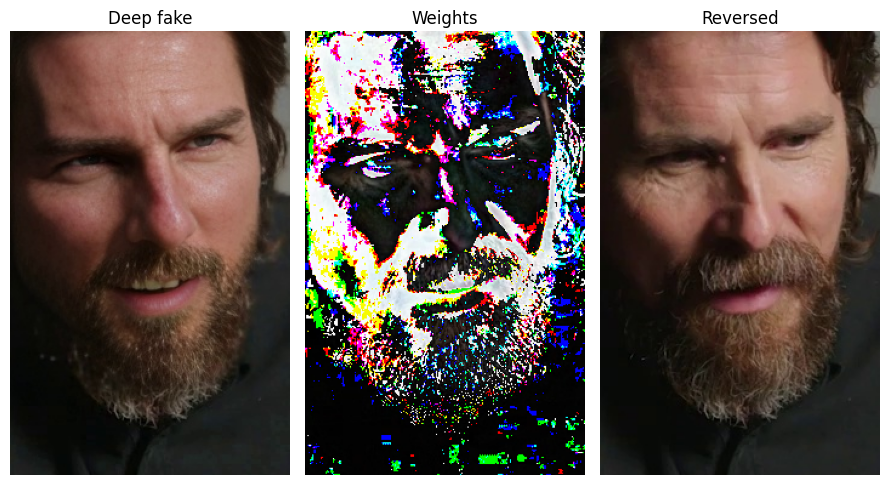

In [236]:
fig, axes = plt.subplots(1, 3, figsize=(9,6))
captions = ['Deep fake','Weights', 'Reversed']

axes[0].imshow(cv2.cvtColor(fake_image_array, cv2.COLOR_BGR2RGB))
axes[0].set_title(captions[0])
axes[0].axis('off')

axes[1].imshow(cv2.cvtColor(weight_array, cv2.COLOR_BGR2RGB))
axes[1].set_title(captions[1])
axes[1].axis('off')

axes[2].imshow(cv2.cvtColor(reversed_array, cv2.COLOR_BGR2RGB))
axes[2].set_title(captions[2])
axes[2].axis('off')

plt.tight_layout()
plt.show()